In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
cd '/content/drive/My Drive/NLP_Project_Toxicity'

/content/drive/My Drive/NLP_Project_Toxicity


In [0]:
#!scripts/download_glove.sh

#1. Dataset Load and EDA

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

#load Train and Test data
toxic_kaggle_train = pd.read_csv('data/Kaggle/train.csv')
toxic_kaggle_test = pd.read_csv('data/Kaggle/test.csv')

In [0]:
toxic_kaggle_train.drop(['id'],axis=1)[(toxic_kaggle_train['toxic']!=0) | (toxic_kaggle_train['severe_toxic'] != 0)].head(5)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


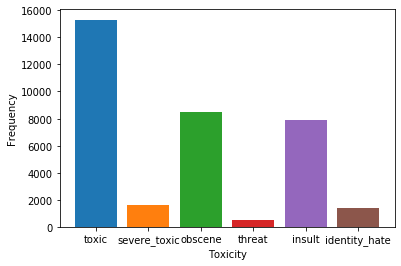

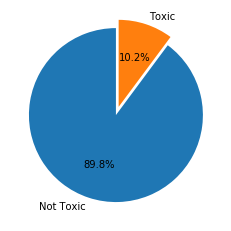

In [0]:
#Initial EDA

toxic_cols = toxic_kaggle_train.drop(['id', 'comment_text'],axis=1).columns

#No. of entries for each toxic sub-type
for col in toxic_cols:
  plt.bar(col,toxic_kaggle_train[col][toxic_kaggle_train[col]==1].count())

plt.xlabel('Toxicity')
plt.ylabel('Frequency')
plt.show()

#No. of toxic entries
bin_label_dict={}
bin_label_dict['Not Toxic']=len(toxic_kaggle_train[(toxic_kaggle_train[toxic_cols] == 0).all(axis=1)])
bin_label_dict['Toxic'] = toxic_kaggle_train.shape[0] - bin_label_dict['Not Toxic']

plt.pie(bin_label_dict.values(), explode=(0.0,0.1), labels=bin_label_dict.keys(), autopct='%1.1f%%',startangle=90)

plt.show()

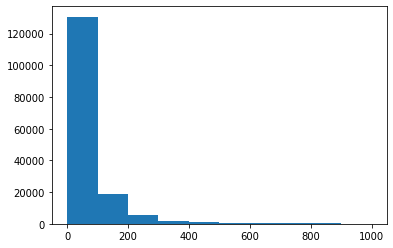

count    159571.000000
mean         67.866962
std         100.520204
min           1.000000
25%          17.000000
50%          36.000000
75%          76.000000
max        2273.000000
Name: tokens, dtype: float64

In [0]:
#No. of words per comment
toxic_kaggle_train['tokens']=(toxic_kaggle_train['comment_text'].str.count(" ")+1)
plt.hist(toxic_kaggle_train['tokens'], bins=10, range=(0,1000))
plt.show()
toxic_kaggle_train['tokens'].describe()

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,GRU,Dropout,Average,Lambda

#2. Pre-processing

In [0]:
emoticons_happy = set([
    ':-\)', ':\)', ';\)', ':o\)', ':]', ':3', ':c\)', ':>', '=]', '8\)', '=\)', ':}',
    ':^\)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-\)\)', ":'-\)", ":'\)", ':\*', ':^\*', '>:P', ':-P', ':P', 
    ':-p', ':p', '=p', ':-b', ':b', '>:\)', '>;\)', '>:-\)',
    '<3'
    ])
# Sad Emoticons
emoticons_sad = set([
    ':L ', ':-/', '>:/', ':S ', ':\@', ':-\(', ':-\|', '=L ', ':<',
    ':-<', '=\\\\', '=/', '>:\(', ':\(', '>.<', ":'-\(", ":'\(", ':\\\\', ':-c',
    ':c', ':{', '>:\\\\', ';\('
    ])

In [0]:
import re
import string

#Preprocessing
toxic_kaggle_train_cp = toxic_kaggle_train.copy()
toxic_kaggle_test_cp = toxic_kaggle_test.copy()

datasets_dict = {'Train': toxic_kaggle_train_cp,'Test': toxic_kaggle_test_cp}

for name, dataset in datasets_dict.items():
  print('\nPre-processing for {} dataset'.format(name))
  dataset['tokens']=(dataset['comment_text'].str.count(" ")+1)
  # replaceips
  dataset['comment_text'].map(lambda x: re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' ip ', x))

  #remove urls
  dataset['comment_text'].map(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x, flags=re.MULTILINE))

  #replace emoticons
  for emoticon in emoticons_happy:
    dataset['comment_text']=dataset['comment_text'].str.replace(emoticon, " happy ")

  for emoticon in emoticons_sad:
    dataset['comment_text']=dataset['comment_text'].str.replace(emoticon, " sad ")

  dataset['comment_text']=dataset['comment_text'].str.replace(r"[\"\',]", '')
  dataset['comment_text']=dataset['comment_text'].str.replace(r":", ' ')
  dataset['comment_text']=dataset['comment_text'].str.replace("(UTC)", "")
  dataset['comment_text']=dataset['comment_text'].str.replace("\n", " ")
  dataset['comment_text']=dataset['comment_text'].str.replace("  ", " ")

  #Replace timestamps 
  dataset['comment_text']=dataset['comment_text'].str.replace(
      "\d{2}:\d{2}[,]\s+(Jan(uary)?|Feb(ruary)?|Mar(ch)?|Apr(il)?|May|Jun(e)?|Jul(y)?|Aug(ust)?|Sep(tember)?|Oct(ober)?|Nov(ember)?|Dec(ember)?)\s+\d{1,2},\s+\d{4}", "")

  #Punctuation to actual tokens
  dataset['comment_text']=dataset['comment_text'].str.translate(str.maketrans({key: " {0}".format(key) for key in string.punctuation}))
  dataset['comment_text']=dataset['comment_text'].str.replace("\. \. \.", "...")

  dataset['comment_text']=dataset['comment_text'].str.strip()


  # replacenumbers and symbols with language
  dataset['comment_text'] = dataset['comment_text'].str.replace('&', ' and ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('=', '')
  dataset['comment_text'] = dataset['comment_text'].str.replace('@', ' at ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('0', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('1', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('2', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('3', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('4', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('5', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('6', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('7', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('8', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('9', ' # ')


  #Start the comment from the first valid letter/number
  alpha_numeric_cmmnts = []
  for comment in dataset['comment_text']:
    match=re.search(r"[^\W\d]|\d", comment)
    if match is not None:
      alpha_numeric_cmmnts.append(comment[match.start():])
    else:
      alpha_numeric_cmmnts.append(comment)
  dataset['comment_text'].update(pd.Series(alpha_numeric_cmmnts))

  for col in dataset.columns:
    print("Column: {}, Null Values: {}".format(col,dataset[col].isnull().sum()))


Pre-processing for Train dataset
Column: id, Null Values: 0
Column: comment_text, Null Values: 0
Column: toxic, Null Values: 0
Column: severe_toxic, Null Values: 0
Column: obscene, Null Values: 0
Column: threat, Null Values: 0
Column: insult, Null Values: 0
Column: identity_hate, Null Values: 0
Column: tokens, Null Values: 0

Pre-processing for Test dataset
Column: id, Null Values: 0
Column: comment_text, Null Values: 0
Column: tokens, Null Values: 0


* ### Below cells are for translation which we did not use for our final model as it took time and did not get us much improvement on our final task.

In [0]:
# !pip install --upgrade polyglot
# !apt update && apt install python-numpy python3-icu
# !pip install pycld2
# !pip install morfessor
# !polyglot download transliteration2.eu
# !polyglot download transliteration2.el

In [0]:
# import polyglot
# from polyglot.text import Text, Word
# from polyglot.transliteration import Transliterator

# from polyglot.downloader import downloader
# print(downloader.supported_languages_table("transliteration2"))

# comments = [Text(x) for x in list(toxic_kaggle_train_cp['comment_text'].values)]
# print(type(comments))
# print(len(comments))

# transliterators = {}

# ignore_langs = set(['en', 'un', 'ia', 'jw', 'vo', 'pl'])

# for comment in comments:
#   try:
#     if comment.language.code not in ignore_langs:
#       if (comment.language.code) in transliterators:
#         transliterator = transliterator[comment.language.code]
#       else:
#         transliterator = Transliterator(source_lang=comment.language.code, target_lang="en")
#         transliterators[comment.language.code] = transliterator

#       comment = transliterator.transliterate(comment.raw)
#   except:
#     pass

# print(len(comments))

In [0]:
# !pip install googletrans

In [0]:
# from googletrans import Translator
# translator = Translator()
# comments = list(toxic_kaggle_train_cp['comment_text'].values)
# print(type(comments))
# print(len(comments))

# detections = translator.detect(comments)
# to_translate = []
# for index, detection in enumerate(detections):
#   if detection.lang != 'en':
#     to_translate.append(index)

# translations_required = [comments[i] for i in to_translate]
# print(len(translations_required))

# translations = translator.translate(translations_required, dest='en')
# print(len(translations))
# # print([translation.text for translation in translations])

# counter = 0
# for i in to_translate:
#   comments[i] = translations[counter]
#   counter += 1

# print(comments[0])

In [0]:
from googletrans import Translator
translator = Translator()
comments = list(toxic_kaggle_train_cp['comment_text'].values)
print(type(comments))
print(len(comments))

detections = translator.detect(comments)
to_translate = []
for index, detection in enumerate(detections):
  if detection.lang != 'en':
    to_translate.append(index)

translations_required = [comments[i] for i in to_translate]
print(len(translations_required))

translations = translator.translate(translations_required, dest='en')
print(len(translations))
# print([translation.text for translation in translations])

counter = 0
for i in to_translate:
  comments[i] = translations[counter]
  counter += 1

print(comments[0])

#3. Up-sampling

In [0]:
from sklearn.utils import resample
# Separate majority and minority classes
toxic_kaggle_train_cp_minority = toxic_kaggle_train_cp[(toxic_kaggle_train_cp["severe_toxic"]==1)|
                                              (toxic_kaggle_train_cp["threat"]==1)|
                                              (toxic_kaggle_train_cp["identity_hate"]==1)]
 
# Upsample minority class
toxic_kaggle_train_cp_minority_upsampled = resample(toxic_kaggle_train_cp_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=24000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
toxic_kaggle_train_cp_upsampled = toxic_kaggle_train_cp.append(toxic_kaggle_train_cp_minority_upsampled)
 

# 4.Baseline Model Creation

In [0]:
import numpy as np
from typing import List, Dict
from tqdm import tqdm
#load embeddings
def load_glove_embeddings(embeddings_txt_file: str,
                          embedding_dim: int,
                          vocab_token_to_id: Dict[str, int]) -> np.ndarray:
    """
    Given a vocabulary (mapping from index to token), this function builds
    an embedding matrix of vocabulary size in which ith row vector is an
    entry from pretrained embeddings (loaded from embeddings_txt_file).
    """
    tokens_to_keep = set(vocab_token_to_id.keys())
    vocab_size = len(vocab_token_to_id)

    embeddings = {}
    print("\nReading pretrained embedding file.")
    with open(embeddings_txt_file, encoding='UTF-8') as file:
        for line in tqdm(file):
            line = str(line).strip()
            token = line.split(' ', 1)[0]
            if not token in tokens_to_keep:
                continue
            fields = line.rstrip().split(' ')
            if len(fields) - 1 != embedding_dim:
                raise Exception(f"Pretrained embedding vector and expected "
                                f"embedding_dim do not match for {token}.")
                continue
            vector = np.asarray(fields[1:], dtype='float32')
            embeddings[token] = vector

    # Estimate mean and std variation in embeddings and initialize it random normally with it
    all_embeddings = np.asarray(list(embeddings.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_std = float(np.std(all_embeddings))

    embedding_matrix = np.random.normal(embeddings_mean, embeddings_std,
                                        (vocab_size+1, embedding_dim))
    embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

    for token, idx in vocab_token_to_id.items():
        if token in embeddings:
            embedding_matrix[idx] = embeddings[token]

    return embedding_matrix


In [0]:
cd '/content/drive/My Drive/NLP_Project_Toxicity/'

/content/drive/My Drive/NLP_Project_Toxicity


In [0]:
embedding_dim = 0
vocabulary = None
embedding_matrix = None

def load_embedding_type(embedding_type = 'glove'):
  global embedding_matrix, embedding_dim
  if embedding_type == 'glove':
    # Glove
    embedding_dim = 300
    vocabulary = {k: word_index[k] for k in list(word_index)[:VOCAB_SIZE-1]}
    embedding_matrix=load_glove_embeddings('data/Embeddings/glove.6B.300d.txt', embedding_dim, vocabulary)
  elif embedding_type == 'twitter':
    embedding_dim = 200
    vocabulary = {k: word_index[k] for k in list(word_index)[:VOCAB_SIZE-1]}
    embedding_matrix=load_glove_embeddings('data/Embeddings/glove.twitter.27B.200d.txt', embedding_dim, vocabulary)
  elif embedding_type == 'crawl':
    # FastText
    embedding_dim = 300
    vocabulary = {k: word_index[k] for k in list(word_index)[:VOCAB_SIZE-1]}
    embedding_matrix=load_glove_embeddings('data/Embeddings/fasttext-crawl-300d-2M.txt', embedding_dim, vocabulary)  
  else:
    # FastText
    embedding_dim = 300
    vocabulary = {k: word_index[k] for k in list(word_index)[:VOCAB_SIZE-1]}
    embedding_matrix=load_glove_embeddings('data/Embeddings/fasttext-wiki-news-300d-1M-subword.txt', embedding_dim, vocabulary)

In [0]:
"""Module to vectorize data.

Converts the given training and validation texts into numerical tensors.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
VOCAB_SIZE = 30000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_NUM_TOKENS = 100


def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        training_instances, validation_instances, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=VOCAB_SIZE)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    training_instances = tokenizer.texts_to_sequences(train_texts)
    validation_instances = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(training_instances, key=len))
    if max_length > MAX_NUM_TOKENS:
        max_length = MAX_NUM_TOKENS

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    training_instances = sequence.pad_sequences(training_instances, maxlen=max_length)
    validation_instances = sequence.pad_sequences(validation_instances, maxlen=max_length)
    return training_instances, validation_instances, tokenizer.word_index

In [0]:
from tensorflow.python.keras import models
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense, GRU,LSTM
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding,Input
from tensorflow.python.keras.layers import SeparableConv1D,SpatialDropout1D
from tensorflow.python.keras.layers import MaxPooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.python.keras.layers import GlobalAveragePooling1D,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
import tensorflow as tf

In [0]:
#Load Model based on choice

CURRENT_EMBEDDINGS=""
def build_model(model_name='DAN', embedding_type='glove', classification_type='multi_label'):
  global CURRENT_EMBEDDINGS, MAX_NUM_TOKENS, embedding_dim
  if embedding_type != CURRENT_EMBEDDINGS:
    load_embedding_type(embedding_type)
    CURRENT_EMBEDDINGS = embedding_type
    
  if classification_type == 'multi_label':
    output_units = 6
  else:
    output_units = 1 

  inp = tf.keras.layers.Input(shape=(MAX_NUM_TOKENS, ))
  x = Embedding(VOCAB_SIZE, embedding_dim, weights=[embedding_matrix])(inp)
    
  if model_name == 'DAN':
    #Multi-layered DAN
    print("DAN Model")
    x = tf.keras.layers.Dropout(0.2)(x)
    x = Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(x)
    for i in range(4):
      x = Dense(embedding_dim, activation="sigmoid")(x)
    outp = Dense(output_units, activation="sigmoid")(x)
  elif model_name == 'GRU':
    #Multi-layered GRU
    print("Multi-layered GRU")
    for i in range(3):
      x = GRU(embedding_dim, dropout=0.2, return_sequences=True, return_state=True)(x)
    x = GRU(embedding_dim, dropout=0.2)(x)  
    outp = Dense(output_units, activation="sigmoid")(x)
  else:
    #Bi-GRU with Pooling
    print("Bi-GRU with Max and Avg Pooling")
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(GRU(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(output_units, activation="sigmoid")(conc)
  model = Model(inputs=inp, outputs=outp)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [0]:
#Multi-label Classification - Training and Test data
import numpy as np
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_labels = list(toxic_kaggle_train_cp_upsampled[list_classes].values)
list_sentences_train = list(toxic_kaggle_train_cp_upsampled["comment_text"].values)
list_sentences_test = list(toxic_kaggle_test_cp["comment_text"].values)

In [0]:
#Vectorize Training and Test data
training_instances, validation_instances, word_index = sequence_vectorize(list_sentences_train,list_sentences_test)

In [0]:
#Multi label Classification-Divide Training data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_instances, 
                                                    train_labels, test_size=0.1,random_state=102)

# 5.Model Training

In [0]:
#Pipeline
import os
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix


experiments = ['DAN','GRU','Bi-GRU']
embedding_types = ["glove","crawl","fasttext","twitter"]
classification_type = 'multi_label'

batch_size = 1000

for experiment in experiments:
  for embedding_type in embedding_types:
    model = build_model(experiment, embedding_type=embedding_type)
    history = model.fit(X_train, tf.constant(y_train),validation_data=(X_test, tf.constant(y_test)), batch_size=batch_size,
            epochs=3, verbose=1)
    
    #Classification Report Generation
    Y_pred = model.predict(X_test)
    y_pred = (Y_pred>0.5).astype(int)
    print('\nClassification Report ({}):\n'.format(experiment),classification_report(np.array(y_test),y_pred,target_names=list_classes),'\n')
    
    print('\nGenerating submission.csv for Kaggle')

    validation_labels=model.predict(validation_instances)
    
    #Submission Dataframe
    submission=pd.DataFrame()
    submission['id']=toxic_kaggle_test_cp['id']
    submission=submission.join(pd.DataFrame(data=validation_labels[0:,0:],columns=list_classes))

    #Generate csv
    submission.to_csv('/content/drive/My Drive/NLP_Project_Toxicity/data/Kaggle/Submissions/{}_{}_upsampled.csv'.format(experiment, embedding_type),index=False)
    print("CSV Submission file saved for {}".format(experiment))
    # Save the model
    print("\nPersisting Model for future")
    directory = 'outputs/'+experiment+'/'+classification_type
    if not os.path.exists(directory):
      os.makedirs(directory)
    model.save(directory+'/persisted_model.h5')
    print("Model saved for {}".format(experiment))





Reading pretrained embedding file.



0it [00:00, ?it/s]
1625it [00:00, 16239.72it/s]
3300it [00:00, 16389.19it/s]
4975it [00:00, 16493.41it/s]
6659it [00:00, 16593.49it/s]
8605it [00:00, 17358.63it/s]
10674it [00:00, 18236.64it/s]
12857it [00:00, 19181.72it/s]
15058it [00:00, 19950.52it/s]
17468it [00:00, 21036.87it/s]
20563it [00:01, 23270.72it/s]
23898it [00:01, 25588.94it/s]
27746it [00:01, 28445.94it/s]
32120it [00:01, 31777.23it/s]
37541it [00:01, 36277.25it/s]
43774it [00:01, 41477.86it/s]
51003it [00:01, 47548.18it/s]
59543it [00:01, 54837.62it/s]
69849it [00:01, 63788.28it/s]
78625it [00:01, 69481.97it/s]
88352it [00:02, 75995.01it/s]
97868it [00:02, 80880.47it/s]
108306it [00:02, 86738.61it/s]
118532it [00:02, 90839.64it/s]
131241it [00:02, 99328.00it/s]
146084it [00:02, 110270.28it/s]
161486it [00:02, 120541.93it/s]
176984it [00:02, 129150.58it/s]
190651it [00:02, 129789.44it/s]
204158it [00:02, 127554.04it/s]
219516it [00:03, 134379.42it/s]
234290it [00:03, 138126.55it/s]
252677it [00:03, 149266.35it/s]
272485

Bi-GRU with Max and Avg Pooling
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 160)     182880      spatial_dropout1d[0][0]          
______________________________________________________________

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)



Classification Report (Bi-GRU):
                precision    recall  f1-score   support

        toxic       0.93      0.90      0.91      3787
 severe_toxic       0.79      0.83      0.81      1372
      obscene       0.94      0.93      0.93      2747
       threat       0.86      0.77      0.81       417
       insult       0.89      0.90      0.89      2675
identity_hate       0.89      0.90      0.90      1284

    micro avg       0.90      0.89      0.90     12282
    macro avg       0.88      0.87      0.88     12282
 weighted avg       0.90      0.89      0.90     12282
  samples avg       0.18      0.18      0.17     12282
 


Generating submission.csv for Kaggle
CSV Submission file saved for Bi-GRU

Persisting Model for future



0it [00:00, ?it/s]
1250it [00:00, 12497.66it/s]

Model saved for Bi-GRU

Reading pretrained embedding file.



2619it [00:00, 12830.53it/s]
4105it [00:00, 13377.65it/s]
5553it [00:00, 13688.92it/s]
7120it [00:00, 14226.45it/s]
8822it [00:00, 14962.90it/s]
10691it [00:00, 15910.68it/s]
12587it [00:00, 16716.91it/s]
14720it [00:00, 17872.89it/s]
16940it [00:01, 18978.59it/s]
19405it [00:01, 20382.51it/s]
22137it [00:01, 22062.67it/s]
25150it [00:01, 23985.14it/s]
28810it [00:01, 26746.87it/s]
32563it [00:01, 29269.69it/s]
37245it [00:01, 32975.41it/s]
42838it [00:01, 37605.22it/s]
49133it [00:01, 42766.35it/s]
56622it [00:01, 49077.51it/s]
64910it [00:02, 55917.02it/s]
71329it [00:02, 47682.33it/s]
80259it [00:02, 55432.21it/s]
88233it [00:02, 61006.46it/s]
95575it [00:02, 64260.64it/s]
103115it [00:02, 67225.24it/s]
111271it [00:02, 70965.12it/s]
119031it [00:02, 72810.31it/s]
126655it [00:02, 73786.32it/s]
134399it [00:03, 67313.41it/s]
141958it [00:03, 69578.74it/s]
149448it [00:03, 71085.77it/s]
157005it [00:03, 72373.97it/s]
164561it [00:03, 73300.31it/s]
172064it [00:03, 73810.70it/s]
1796

Bi-GRU with Max and Avg Pooling
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     9000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 160)     182880      spatial_dropout1d_1[0][0]        
____________________________________________________________


0it [00:00, ?it/s]
2010it [00:00, 20096.71it/s]

Model saved for Bi-GRU

Reading pretrained embedding file.



4253it [00:00, 20743.94it/s]
7051it [00:00, 22487.79it/s]
9867it [00:00, 23930.68it/s]
13132it [00:00, 26012.85it/s]
17154it [00:00, 29086.51it/s]
21511it [00:00, 32308.28it/s]
26532it [00:00, 36176.39it/s]
31491it [00:00, 39366.14it/s]
38068it [00:01, 44756.43it/s]
43923it [00:01, 48148.37it/s]
50170it [00:01, 51075.74it/s]
57657it [00:01, 56458.43it/s]
63760it [00:01, 57754.71it/s]
70768it [00:01, 60969.08it/s]
78689it [00:01, 65486.65it/s]
86572it [00:01, 68969.62it/s]
95630it [00:01, 74278.56it/s]
105263it [00:01, 79753.70it/s]
115082it [00:02, 84513.13it/s]
125204it [00:02, 87348.85it/s]
134169it [00:02, 88022.83it/s]
143134it [00:02, 61164.74it/s]
152985it [00:02, 69009.28it/s]
162988it [00:02, 76085.61it/s]
172276it [00:02, 80449.26it/s]
182045it [00:02, 84946.60it/s]
191698it [00:02, 88117.06it/s]
201518it [00:03, 90915.90it/s]
211370it [00:03, 93070.35it/s]
221412it [00:03, 95159.26it/s]
231154it [00:03, 95819.60it/s]
241028it [00:03, 96672.71it/s]
250886it [00:03, 97234.73it

Bi-GRU with Max and Avg Pooling
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 200)     6000000     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 100, 200)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 160)     134880      spatial_dropout1d_2[0][0]        
____________________________________________________________

**BERT Experiments**

In [0]:
# !wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
# !chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
# !bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
# !conda install -q -y --prefix /usr/local -c pytorch -c tensorcomp tensor_comprehensions

# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [0]:
#Install pytorch cudatoolkit ---> Requirement for simple transformer wrapper
!conda install pytorch cudatoolkit=10.0 -c pytorch

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [0]:
#Get embeddings from codalab.org
#!wget -O data/Embeddings/fasttext-crawl-300d-2M.txt https://worksheets.codalab.org/rest/bundles/0x3c8503f4e1e345c99cc8aa9009dbb692/contents/blob/

--2019-12-09 09:18:25--  https://worksheets.codalab.org/rest/bundles/0x3c8503f4e1e345c99cc8aa9009dbb692/contents/blob/
Resolving worksheets.codalab.org (worksheets.codalab.org)... 40.71.231.153
Connecting to worksheets.codalab.org (worksheets.codalab.org)|40.71.231.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Syntax error in Set-Cookie: codalab_session=""; expires=Thu, 01 Jan 1970 00:00:00 GMT; Max-Age=-1; Path=/ at position 70.
Length: unspecified [text/plain]
Saving to: ‘data/Embeddings/fasttext-crawl-300d-2M.txt’

data/Embeddings/fas     [             <=>    ]   4.21G  40.9MB/s    in 1m 40s  

2019-12-09 09:20:05 (43.2 MB/s) - ‘data/Embeddings/fasttext-crawl-300d-2M.txt’ saved [4516698354]



In [0]:
!pip install simpletransformers

     |████████████████████████████████| 1.3MB 2.9MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
  Found existing installation: protobuf 3.4.1
    Uninstalling protobuf-3.4.1:
      Successfully uninstalled protobuf-3.4.1


#  6.BERT Loading and Training

In [0]:
#Load Wrapper Model (Bert/distillBert)
from simpletransformers.classification import MultiLabelClassificationModel

model = MultiLabelClassificationModel('bert', 'bert-base-uncased', num_labels=6, args={'train_batch_size':32,'gradient_accumulation_steps':16, 'learning_rate': 3e-5, 'num_train_epochs': 2, 'max_seq_length': 200, "output_dir": "outputs/BERT",
    "cache_dir": "cache_dir/BERT/",})

In [0]:
#Multi label Classification-Divide Training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(list_sentences_train, 
                                                    train_labels, test_size=0.1,random_state=102)

In [0]:
bert_df = pd.DataFrame()
bert_df['text'] = X_train
bert_df['labels'] = list(y_train)

In [0]:
model.train_model(bert_df)

Converting to features started.


Running loss: 0.028111

Running loss: 0.019458Training of distilbert model complete. Saved to outputs/distillBERT_noscale.


In [0]:
#Evaluate BERT Model

eval_df = pd.DataFrame()
eval_df['text'] = X_test
eval_df['labels'] = list(y_test)
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

Converting to features started.


In [0]:
preds, outputs = model.predict(toxic_kaggle_test_cp['comment_text'])

Converting to features started.


In [0]:
validation_labels = outputs

In [0]:
validation_labels_conv=(validation_labels>0.5).astype(int)

In [0]:
#BERT Pipeline
bert_models_dict = {'':'bert'}

for model_location, model_name in bert_models_dict.items():
  print(model_name+":\n")
  model = MultiLabelClassificationModel(model_name,"outputs/"+model_location, num_labels=6, args={'train_batch_size':32,'gradient_accumulation_steps':16, 'learning_rate': 3e-5, 'num_train_epochs': 2, 'max_seq_length': 200, "output_dir": "outputs/"+model_location,
    "cache_dir": "cache_dir/"+model_location})
  preds, outputs = model.predict(eval_df['text'])
  print('\nClassification Report ({}):\n'.format(model_name),classification_report(np.asarray(y_test),np.asarray(preds),target_names=list_classes),'\n')

  #Submission Dataframe
  preds, outputs = model.predict(toxic_kaggle_test_cp['comment_text'])
  submission=pd.DataFrame()
  submission['id']=toxic_kaggle_test_cp['id']
  submission=submission.join(pd.DataFrame(data=outputs[0:,0:],columns=list_classes))

  #Generate csv
  submission.to_csv('/content/drive/My Drive/NLP_Project_Toxicity/data/Kaggle/Submissions/BERT_upsampled.csv'.format(experiment, embedding_type),index=False)
  print("CSV Submission file saved for {}".format(experiment))

bert:

Converting to features started.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)



Classification Report (bert):
                precision    recall  f1-score   support

        toxic       0.91      0.94      0.92      3787
 severe_toxic       0.83      0.95      0.88      1372
      obscene       0.92      0.97      0.94      2747
       threat       0.94      0.99      0.97       417
       insult       0.89      0.95      0.92      2675
identity_hate       0.91      0.98      0.94      1284

    micro avg       0.90      0.95      0.92     12282
    macro avg       0.90      0.96      0.93     12282
 weighted avg       0.90      0.95      0.92     12282
  samples avg       0.18      0.20      0.19     12282
 

Converting to features started.


CSV Submission file saved for Bi-GRU


# 7.Binary Classication 

In [0]:
#Dataset for binary classification
binary_kaggle_train = toxic_kaggle_train_cp_upsampled.copy()
binary_kaggle_train['isToxic'] = binary_kaggle_train['toxic'] | binary_kaggle_train['severe_toxic']

In [0]:
np.unique(binary_kaggle_train['isToxic'],return_counts=True)

(array([0, 1]), array([145325,  38246]))

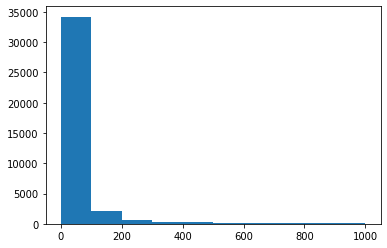

count    38246.000000
mean        57.696360
std        139.994423
min          1.000000
25%         10.000000
50%         20.000000
75%         43.000000
max       2041.000000
Name: tokens, dtype: float64

In [0]:
#No. of words per comment for toxic comments
toxic_series=binary_kaggle_train['tokens'][binary_kaggle_train['isToxic']==1]
plt.hist(toxic_series, bins=10, range=(0,1000))
plt.show()
toxic_series.describe()

In [0]:
#Binary Classification
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(binary_kaggle_train['comment_text'], 
           binary_kaggle_train['isToxic'], test_size=0.30,random_state=102)
train_labels = list(y_train.values)
test_labels = list(y_test.values)
list_sentences_train = list(X_train.values)
list_sentences_test = list(X_test.values) 

In [0]:
#Vectorize Training and Test data
X_train, X_test, word_index = sequence_vectorize(list_sentences_train,list_sentences_test)

In [0]:
#Pipeline
import os
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix


experiments = ['Bi-GRU']
embedding_types = ["twitter"]

batch_size = 1000

for experiment in experiments:
  for embedding_type in embedding_types:
    model = build_model(experiment, embedding_type=embedding_type,classification_type='binary')
    history = model.fit(X_train, tf.constant(y_train),validation_data=(X_test, tf.constant(y_test)), batch_size=batch_size,
            epochs=3, verbose=1)
    
    #Classification Report Generation
    Y_pred = model.predict(X_test)
    y_pred = (Y_pred>0.5).astype(int)
    print('\nClassification Report ({}):\n'.format(experiment),classification_report(np.array(y_test),y_pred,target_names=['Non-Toxic','Toxic']),'\n')
    
    # Save the model
    print("\nPersisting Model for future")
    directory = 'outputs/'+experiment+'/binary'
    if not os.path.exists(directory):
      os.makedirs(directory)
    model.save(directory+'/persisted_model.h5')
    print("Model saved for {}".format(experiment))




Bi-GRU with Max and Avg Pooling
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 200)     6000000     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 100, 200)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 160)     134880      spatial_dropout1d_5[0][0]        
____________________________________________________________

# 8.Transfer Learning Experiment (Twitter Database)

In [0]:
#load Train and Test data
toxic_twitter_validation = pd.read_csv('data/Twitter/filtered_twitter_data.csv')

In [0]:
#Making dataset consisting with out model requirements

toxic_twitter_validation.drop(['no. of turks'],inplace=True,axis=1)
spams = toxic_twitter_validation['label'] == 'spam'
toxic_twitter_validation.drop(toxic_twitter_validation.index[spams],inplace=True)
toxic_twitter_validation['isToxic'] = (toxic_twitter_validation['label'] != 'normal').astype(int)
toxic_twitter_validation = toxic_twitter_validation.rename(columns={"tweet": "comment_text"})

In [0]:
import re
import string

#Preprocessing
toxic_twitter_test_cp = toxic_twitter_validation.copy()

datasets_dict = {'Test': toxic_twitter_test_cp}

for name, dataset in datasets_dict.items():
  print('\nPre-processing for {} dataset'.format(name))
  dataset['tokens']=(dataset['comment_text'].str.count(" ")+1)

  # replaceips
  dataset['comment_text'].map(lambda x: re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' ip ', x))

  #remove urls
  dataset['comment_text'].map(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', ' ', x, flags=re.MULTILINE))

  #replace emoticons
  for emoticon in emoticons_happy:
    dataset['comment_text']=dataset['comment_text'].str.replace(emoticon, " happy ")

  for emoticon in emoticons_sad:
    dataset['comment_text']=dataset['comment_text'].str.replace(emoticon, " sad ")

  dataset['comment_text']=dataset['comment_text'].str.replace(r"[\"\',]", '')
  dataset['comment_text']=dataset['comment_text'].str.replace(r":", ' ')
  dataset['comment_text']=dataset['comment_text'].str.replace("(UTC)", "")
  dataset['comment_text']=dataset['comment_text'].str.replace("RT ", " ")
  dataset['comment_text']=dataset['comment_text'].str.replace("\n", " ")
  dataset['comment_text']=dataset['comment_text'].str.replace("  ", " ")

  #Replace timestamps 
  dataset['comment_text']=dataset['comment_text'].str.replace(
      "\d{2}:\d{2}[,]\s+(Jan(uary)?|Feb(ruary)?|Mar(ch)?|Apr(il)?|May|Jun(e)?|Jul(y)?|Aug(ust)?|Sep(tember)?|Oct(ober)?|Nov(ember)?|Dec(ember)?)\s+\d{1,2},\s+\d{4}", "")

  #Punctuation to actual tokens
  dataset['comment_text']=dataset['comment_text'].str.translate(str.maketrans({key: " {0}".format(key) for key in string.punctuation}))
  dataset['comment_text']=dataset['comment_text'].str.replace("\. \. \.", "...")

  dataset['comment_text']=dataset['comment_text'].str.strip()


  dataset['comment_text'].map(lambda x: re.sub('@[^\s]+',' ',x))
  # replacenumbers and symbols with language
  dataset['comment_text'] = dataset['comment_text'].str.replace('&', ' and ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('=', '')
  dataset['comment_text'] = dataset['comment_text'].str.replace('@', ' at ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('0', ' zero ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('1', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('2', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('3', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('4', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('5', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('6', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('7', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('8', ' # ')
  dataset['comment_text'] = dataset['comment_text'].str.replace('9', ' # ')

  #Start the comment from the first valid letter/number
  alpha_numeric_cmmnts = []
  for comment in dataset['comment_text']:
    match=re.search(r"[^\W\d]|\d", comment)
    if match is not None:
      alpha_numeric_cmmnts.append(comment[match.start():])
    else:
      alpha_numeric_cmmnts.append(comment)
  dataset.reset_index(inplace=True, drop=True) 
  dataset['comment_text'].update(pd.Series(alpha_numeric_cmmnts))

  for col in dataset.columns:
    print("Column: {}, Null Values: {}".format(col,dataset[col].isnull().sum()))


Pre-processing for Test dataset
Column: comment_text, Null Values: 0
Column: label, Null Values: 0
Column: isToxic, Null Values: 0
Column: tokens, Null Values: 0


In [0]:
#Load Saved Bi-GRU Model
from tensorflow.keras.models import load_model
model = load_model('outputs/Bi-GRU/binary/persisted_model.h5')

In [0]:
#Vectorize Training and Test data
X_train, X_test, word_index = sequence_vectorize(list_sentences_train,list(dataset['comment_text']))

Y_pred = model.predict(X_test)
y_pred = (Y_pred>0.5).astype(int)print('\nClassification Report ({}):\n'.format(experiment),classification_report(np.asarray(dataset['isToxic']),y_pred.ravel(),target_names=['Non-Toxic','Toxic']),'\n')


Classification Report (Bi-GRU):
               precision    recall  f1-score   support

   Non-Toxic       0.94      0.95      0.95     53851
       Toxic       0.92      0.89      0.91     32115

    accuracy                           0.93     85966
   macro avg       0.93      0.92      0.93     85966
weighted avg       0.93      0.93      0.93     85966
 

